In [1]:
# Import all libraries
import os
import re
import time
import json
import duckdb
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tqdm import tqdm
from bs4 import BeautifulSoup
from collections import Counter
import geopandas as gpd
from geoalchemy2 import Geometry, WKTElement

## 1. Data Acquisition

In [2]:
os.makedirs("raw_data", exist_ok=True)
os.makedirs("clean_data", exist_ok=True)

# Retrieve Greenhouse and energy information by designated generation facility dataset between 2015-2024 financial years (2014.07.01-2024.6.30)
nger_dataset_num = ["ID0075", "ID0076", "ID0077", "ID0078", "ID0079", "ID0080", "ID0081", "ID0082", "ID0083", "ID0243"]
# Data retrieval and save them as csv files respectively
for i in range(10):
    url = f"https://api.cer.gov.au/datahub-public/v1/api/ODataDataset/NGER/dataset/{nger_dataset_num[i]}?select%3D%2A"
    response = requests.get(url)
    if response.status_code == 200:
        df = pd.json_normalize(response.json())
        df["financialYear"] = 2015 + i
        df.to_csv(f"raw_data/NGER_dataset{2015 + i}.csv", index = False)
    else:
        print(f"{2015 + i} Financial Year Dataset's API Access Failed with Status Code {response.status_code}")

In [3]:
# Retrieve the three CER datasets (accredited, committed, probable)
cer_url = {"accredited": "https://cer.gov.au/document/power-stations-and-projects-accredited",
           "committed": "https://cer.gov.au/document/power-stations-and-projects-committed",
           "probable": "https://cer.gov.au/document/power-stations-and-projects-probable"}
# Data retrieval and save them as csv files respectively
for status, url in cer_url.items():
    df = pd.read_csv(url)
    df.to_csv(f"raw_data/CER_dataset_{status}.csv", index = False)

In [4]:
#Retrieve the Economy and industry, ASGS and LGA, 2011, 2016-2024 dataset
eco_ind_url = "https://www.abs.gov.au/methodologies/data-region-methodology/2011-24/14100DO0003_2011-24.xlsx"

# Table 2 is excluded because the state-level info is in Table 1
ABS_df = pd.read_excel(eco_ind_url, sheet_name = "Table 1", header=6)
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html

# Data retrieval and save it as csv file
ABS_df.to_csv("raw_data/ABS_dataset.csv", index = False)

## 2. Data Integration and Cleaning

### (1) NGER dataset

In [5]:
# NGER datasets integration
nger_column_mapping = {
    "reportingEntity": "reporting_entity", "controllingcorporation": "reporting_entity", "reportingentity": "reporting_entity",
    "facilityName": "facility_name", "facilityname": "facility_name",    
    "electricityProductionGJ": "electricity_production_gj", "electricityproductionGJ": "electricity_production_gj",
    "electricityProductionMwh": "electricity_production_mwh", "electricityProductionMWh": "electricity_production_mwh", "electricityproductionMWh": "electricity_production_mwh",
    "scope1tCO2e": "scope1_emissions_tco2e", "totalScope1EmissionstCO2e": "scope1_emissions_tco2e", "totalscope1emissionstCO2e": "scope1_emissions_tco2e",
    "scope2tCO2e": "scope2_emissions_tco2e", "totalScope2EmissionstCO2e": "scope2_emissions_tco2e", "totalScope2EmissionstCO2e2": "scope2_emissions_tco2e", "totalscope2emissionstCO2e": "scope2_emissions_tco2e",
    "totalEmissionstCO2e": "total_emissions_tco2e", "totalemissionstCO2e": "total_emissions_tco2e",
    "emissionIntensitytMwh": "emission_intensity_tco2emwh", "emissionIntensitytCO2eMWh": "emission_intensity_tco2emwh", "emissionintensitytCO2eMWh": "emission_intensity_tco2emwh",
    "gridConnected": "grid_connected", "gridConnected2": "grid_connected", "gridconnected": "grid_connected",
    "grid": "grid",
    "primaryFuel": "primary_fuel", "primaryfuel": "primary_fuel",
    "importantNotes": "important_notes", "importantnotes": "important_notes",
    "type": "type",
    "state": "state",
    "financialYear": "financial_year"}

nger_all_data = []

for i in range(10):
    df = pd.read_csv(f"raw_data/NGER_dataset{2015 + i}.csv", na_values=["N/A", "-"])
    df = df.rename(columns={col: nger_column_mapping.get(col, col) for col in df.columns})
    nger_all_data.append(df)

NGER_df = pd.concat(nger_all_data, ignore_index = True)
NGER_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   reporting_entity             5942 non-null   object 
 1   facility_name                5936 non-null   object 
 2   type                         5936 non-null   object 
 3   state                        4880 non-null   object 
 4   electricity_production_gj    5938 non-null   float64
 5   electricity_production_mwh   5938 non-null   float64
 6   scope1_emissions_tco2e       5885 non-null   float64
 7   scope2_emissions_tco2e       5764 non-null   float64
 8   total_emissions_tco2e        5942 non-null   int64  
 9   emission_intensity_tco2emwh  4830 non-null   float64
 10  grid_connected               4880 non-null   object 
 11  grid                         4880 non-null   object 
 12  primary_fuel                 4880 non-null   object 
 13  important_notes   

In [6]:
# Identify missing values:
NGER_df.isna().mean().sort_values()

reporting_entity               0.000000
total_emissions_tco2e          0.000000
financial_year                 0.000000
electricity_production_gj      0.000673
electricity_production_mwh     0.000673
facility_name                  0.001010
type                           0.001010
scope1_emissions_tco2e         0.009593
scope2_emissions_tco2e         0.029956
state                          0.178728
grid                           0.178728
grid_connected                 0.178728
primary_fuel                   0.178728
emission_intensity_tco2emwh    0.187142
important_notes                0.993773
dtype: float64

In [7]:
# Drop the rows with missing critical fields
NGER_df = NGER_df.dropna(subset = ["reporting_entity", "facility_name", "electricity_production_gj", "electricity_production_mwh", 
                                   "total_emissions_tco2e"])
NGER_df["facility_name"] = NGER_df["facility_name"].astype(str).str.strip()

In [8]:
# Remove duplications

"""Based on the explanation from the website, type ‘F’ means the row contains information for a facility, and ‘C’ means the row contains information for 
a corporate total. ‘FA’ stands for ‘facility aggregate’ which means that the company has reported a number of facilities together."""
# 1. Drop the rows where type is 'C', as it standands for the Corporate Total for a certain period, which causes duplications
NGER_df = NGER_df[NGER_df["type"] != "C"]


"""Based on the importantNotes, double counting of any facilities can occur if joint operators of a facility do not nominate one of the parties as 
having operational control of the facility."""
# 2. Remove Joint Venture duplicates (i.e. all data in type, state, electricityProductionMWh, scope1EmissionstCO2e, scope2EmissionstCO2e, gridConnected, 
# grid, primaryFuel, importantNotes, financialYear is the same)
dup_keys = [col for col in NGER_df.columns if col not in ["reporting_entity", "facility_name"]]
duplicated_rows = NGER_df.duplicated(subset = dup_keys, keep = "first")
NGER_df = NGER_df[~duplicated_rows].reset_index(drop = True)

In [9]:
# Drop unnecessary columns (ignore if column does not exist)
NGER_df = NGER_df.drop(columns=["important_notes"], errors="ignore")

In [10]:
# Data type conversion based on the original datasets' data definition
cols_int64 = ["electricity_production_gj", "electricity_production_mwh", "scope1_emissions_tco2e", "total_emissions_tco2e"]
for col in cols_int64:
    NGER_df[col] = pd.to_numeric(NGER_df[col], errors="coerce").astype("Int64")

In [11]:
# Fill empty scope1_emissions_tco2e and scope2_emissions_tco2e with 0
NGER_df["scope1_emissions_tco2e"] = NGER_df["scope1_emissions_tco2e"].fillna(0)
NGER_df["scope2_emissions_tco2e"] = NGER_df["scope2_emissions_tco2e"].fillna(0)

# Fill missing emission_intensity_tco2emwh using total_emissions / electricity_production_mwh
NGER_df["emission_intensity_tco2emwh"] = NGER_df["emission_intensity_tco2emwh"].fillna(NGER_df["total_emissions_tco2e"] / NGER_df["electricity_production_mwh"])

In [12]:
#Identify duplicated rows
print("Number of duplicated rows:", NGER_df.duplicated().sum())

Number of duplicated rows: 0


In [13]:
NGER_df.info()
# Save the cleaned dataset
NGER_df.to_csv("clean_data/NGER_clean.csv", index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   reporting_entity             4860 non-null   object 
 1   facility_name                4860 non-null   object 
 2   type                         4860 non-null   object 
 3   state                        4860 non-null   object 
 4   electricity_production_gj    4860 non-null   Int64  
 5   electricity_production_mwh   4860 non-null   Int64  
 6   scope1_emissions_tco2e       4860 non-null   Int64  
 7   scope2_emissions_tco2e       4860 non-null   float64
 8   total_emissions_tco2e        4860 non-null   Int64  
 9   emission_intensity_tco2emwh  4860 non-null   float64
 10  grid_connected               4860 non-null   object 
 11  grid                         4860 non-null   object 
 12  primary_fuel                 4860 non-null   object 
 13  financial_year    

### (2) CER dataset

In [14]:
cer_all_data=[]
# 1. Retrieve, clean and integrate the accredited dataset
df = pd.read_csv(f"raw_data/CER_dataset_accredited.csv")
df.info()

# Drop the unnecessary columns
df.drop(columns=["Accreditation code", "Accreditation start date", "Approval date"], inplace=True)

# Standardize column names 
df.columns = ["facility_name", "state", "postcode", "installed_capacity_mw", "primary_fuel"]

# Extract the facility name, excluding the extra info in the fields
df["facility_name"] = df["facility_name"].str.replace(r'(\s*(?:-|\?€?|\u2013)\s*(solar|wind|lfg|\d+\.?\d*\s*[kK][wW]|NSW|QLD|VIC|SA|WA|NT|ACT).*)$', '',
                                                      regex=True, flags=re.IGNORECASE)
df["facility_name"] = df["facility_name"].str.replace(r'\s*\d+\.?\d*\s*[kK][wW]\s*$', '', regex=True)
df["facility_name"] = df["facility_name"].str.replace(r'\s*(?:-|\?€?|\u2013)\s*$', '', regex=True)
df["facility_name"] = df["facility_name"].str.strip()

# Standardise the postcode following Australian format
df["postcode"] = df["postcode"].astype(str).str.zfill(4)

cer_all_data.append(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Accreditation code        280 non-null    object 
 1   Power station name        280 non-null    object 
 2   State                     280 non-null    object 
 3   Postcode                  280 non-null    int64  
 4   Installed capacity (MW)   280 non-null    float64
 5   Fuel Source (s)           280 non-null    object 
 6   Accreditation start date  280 non-null    object 
 7   Approval date             280 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 17.6+ KB


In [15]:
# 2. Retrieve, clean and integrate the committed dataset
df = pd.read_csv(f"raw_data/CER_dataset_committed.csv")
df.info()

# Drop the unnecessary columns
df.drop(columns=["Committed Date (Month/Year)"], inplace=True)

# Standardize column names 
df.columns = ["facility_name", "state", "installed_capacity_mw", "primary_fuel"]

# df["facility_name"] = df["facility_name"].astype(str).str.strip()

# Extract the facility name, excluding the extra info in the fields
df["facility_name"] = df["facility_name"].str.replace(r'(\s*(?:-|\?€?|\u2013)\s*(solar|wind|lfg|\d+\.?\d*\s*[kK][wW]|NSW|QLD|VIC|SA|WA|NT|ACT).*)$', '',
                                                      regex=True, flags=re.IGNORECASE)
df["facility_name"] = df["facility_name"].str.replace(r'\s*\d+\.?\d*\s*[kK][wW]\s*$', '', regex=True)
df["facility_name"] = df["facility_name"].str.replace(r'\s*(?:-|\?€?|\u2013)\s*$', '', regex=True)
df["facility_name"] = df["facility_name"].str.strip()

cer_all_data.append(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Project Name                 35 non-null     object 
 1   State                        35 non-null     object 
 2   MW Capacity                  35 non-null     float64
 3   Fuel Source                  35 non-null     object 
 4   Committed Date (Month/Year)  35 non-null     object 
dtypes: float64(1), object(4)
memory usage: 1.5+ KB


In [16]:
# 3. Retrieve, clean and integrate the probable dataset
df = pd.read_csv(f"raw_data/CER_dataset_probable.csv")
df.info()

# Standardize column names
df.columns = ["facility_name", "state", "installed_capacity_mw", "primary_fuel"]

# Extract the facility name, excluding the extra info in the fields
df["facility_name"] = df["facility_name"].str.replace(r'(\s*(?:-|\?€?|\u2013)\s*(solar|wind|lfg|\d+\.?\d*\s*[kK][wW]|NSW|QLD|VIC|SA|WA|NT|ACT).*)$', '',
                                                      regex=True, flags=re.IGNORECASE)
df["facility_name"] = df["facility_name"].str.replace(r'\s*\d+\.?\d*\s*[kK][wW]\s*$', '', regex=True)
df["facility_name"] = df["facility_name"].str.replace(r'\s*(?:-|\?€?|\u2013)\s*$', '', regex=True)
df["facility_name"] = df["facility_name"].str.strip()

cer_all_data.append(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Project Name  49 non-null     object 
 1   State         49 non-null     object 
 2   MW Capacity   49 non-null     float64
 3   Fuel Source   49 non-null     object 
dtypes: float64(1), object(3)
memory usage: 1.7+ KB


In [17]:
# 4. Concatenate the three datasets into one
CER_df = pd.concat(cer_all_data, ignore_index=True)
CER_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   facility_name          364 non-null    object 
 1   state                  364 non-null    object 
 2   postcode               280 non-null    object 
 3   installed_capacity_mw  364 non-null    float64
 4   primary_fuel           364 non-null    object 
dtypes: float64(1), object(4)
memory usage: 14.3+ KB


In [18]:
#Identify duplicated rows
print("Number of duplicated rows:", CER_df.duplicated().sum())

Number of duplicated rows: 0


In [19]:
CER_df.info()
CER_df.to_csv("clean_data/CER_clean.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   facility_name          364 non-null    object 
 1   state                  364 non-null    object 
 2   postcode               280 non-null    object 
 3   installed_capacity_mw  364 non-null    float64
 4   primary_fuel           364 non-null    object 
dtypes: float64(1), object(4)
memory usage: 14.3+ KB


### (3) ABS dataset

In [20]:
# Read the raw ABS dataset
ABS_df = pd.read_csv("raw_data/ABS_dataset.csv", low_memory = False)
ABS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29097 entries, 0 to 29096
Columns: 127 entries, Code to Total dwellings (no.)
dtypes: float64(1), object(126)
memory usage: 28.2+ MB


In [21]:
# Filter the irrelevant info
# 1. Focuse on state-level statistics (Code 1-9)
ABS_df = ABS_df[ABS_df["Code"].notna() & ABS_df["Code"].str.isdigit()]
ABS_df = ABS_df[ABS_df["Code"].astype(int).between(1, 9)]

# 2. Filter data for financial year 2015-2024 
ABS_df["Year"] = ABS_df["Year"].astype("Int64")
ABS_df = ABS_df[ABS_df["Year"].between(2015, 2024)]


# 3. Select key economic and industry columns relevant to electricity analysis
col_to_keep = ["Label", "Year", "Total number of businesses", "Total number of business entries", "Total number of business exits"]
ABS_df = ABS_df[col_to_keep]

# 4. Drop rows where all numerical columns are missing
num_cols = col_to_keep[2:]
ABS_df[num_cols] = ABS_df[num_cols].replace("-", np.nan)
ABS_df = ABS_df.dropna(subset=num_cols, how="all").reset_index(drop=True)

In [22]:
# Identify duplicated rows
print("Number of duplicated rows:", ABS_df.duplicated().sum())

Number of duplicated rows: 0


In [23]:
# Data type conversion
cols_to_convert = ["Total number of businesses","Total number of business entries","Total number of business exits"]
ABS_df[cols_to_convert] = ABS_df[cols_to_convert].astype("Int64")

In [24]:
# Standardise the Label class
ABS_df = ABS_df[ABS_df["Label"] != "Other Territories"].copy()

state_mapping = {"New South Wales": "NSW",
                 "Victoria": "VIC",
                 "Queensland": "QLD",
                 "South Australia": "SA",
                 "Western Australia": "WA",
                 "Tasmania": "TAS",
                 "Northern Territory": "NT",
                 "Australian Capital Territory": "ACT"}

ABS_df["Label"] = ABS_df["Label"].map(state_mapping)

ABS_df = ABS_df.rename(columns={"Label": "state"})
ABS_df = ABS_df.rename(columns={"Year": "financial_year"})
ABS_df = ABS_df.rename(columns={"Label": "state", "Year": "financial_year", "Total number of businesses": "total_number_of_businesses",
                                "Total number of business entries": "total_number_of_business_entries",
                                "Total number of business exits": "total_number_of_business_exits"})

In [25]:
ABS_df.info()
ABS_df.to_csv("clean_data/ABS_clean.csv", index = False)

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   state                             40 non-null     object
 1   financial_year                    40 non-null     Int64 
 2   total_number_of_businesses        40 non-null     Int64 
 3   total_number_of_business_entries  32 non-null     Int64 
 4   total_number_of_business_exits    32 non-null     Int64 
dtypes: Int64(4), object(1)
memory usage: 2.0+ KB


### (4) Integration

In [26]:
# Final Integration
NGER_df["flag"] = "NGER"
CER_df["flag"] = "CER"

df = pd.merge(NGER_df, ABS_df, on = ["state", "financial_year"], how = "left")

Integ_df = pd.concat([df, CER_df], axis=0, ignore_index=True)

Integ_df.to_csv("clean_data/Integration_clean.csv", index = False)
Integ_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5224 entries, 0 to 5223
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   reporting_entity                  4860 non-null   object 
 1   facility_name                     5224 non-null   object 
 2   type                              4860 non-null   object 
 3   state                             5224 non-null   object 
 4   electricity_production_gj         4860 non-null   Int64  
 5   electricity_production_mwh        4860 non-null   Int64  
 6   scope1_emissions_tco2e            4860 non-null   Int64  
 7   scope2_emissions_tco2e            4860 non-null   float64
 8   total_emissions_tco2e             4860 non-null   Int64  
 9   emission_intensity_tco2emwh       4860 non-null   float64
 10  grid_connected                    4860 non-null   object 
 11  grid                              4860 non-null   object 
 12  primar

### Data Exploration

In [27]:
Integ_df.describe()

,electricity_production_gj,electricity_production_mwh,scope1_emissions_tco2e,scope2_emissions_tco2e,total_emissions_tco2e,emission_intensity_tco2emwh,financial_year,total_number_of_businesses,total_number_of_business_entries,total_number_of_business_exits,installed_capacity_mw
count,4860.0,4860.0,4860.0,4860.000000,4860.0,4860.000000,4860.000000,2798.0,2287.0,2287.0,364.000000
mean,1650856.161111,458571.108436,328375.505556,3596.611317,331972.116872,0.381726,2019.996296,406656.120443,67513.592042,54682.01268,64.990426
std,6196334.854887,1721204.13841,1700004.815244,26495.989243,1711422.764335,0.598720,2.822889,294194.689049,50447.990352,41527.967012,177.252190
min,0.0,0.0,0.0,0.000000,0.0,0.000000,2015.000000,14547.0,2259.0,1800.0,0.118800
25%,11526.25,3201.5,36.75,0.000000,250.0,0.000000,2018.000000,156131.0,23403.0,20081.0,0.234500
50%,117002.5,32500.5,692.0,8.000000,988.0,0.310000,2020.000000,443911.0,69333.0,53450.0,0.460500
75%,821569.5,228213.5,5958.0,353.250000,7115.25,0.690000,2022.000000,713211.0,114589.0,83288.0,7.696750
max,64634548.0,17954041.0,19861938.0,684673.000000,20107115.0,20.480000,2024.000000,896560.0,149226.0,128785.0,1400.000000


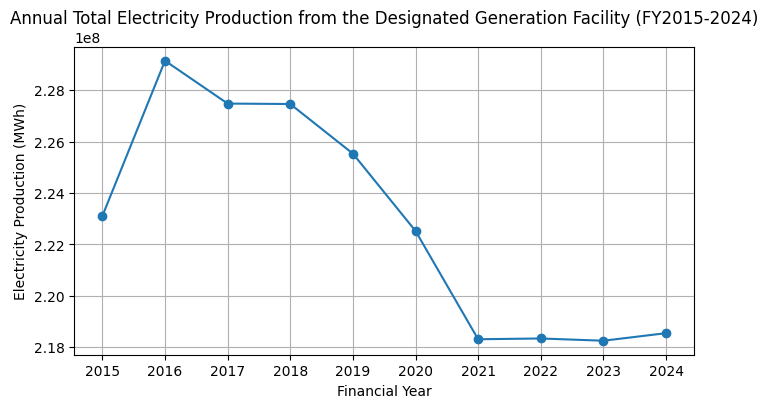

In [28]:
# Data exploration
# 1. Historic trend of electricity production
agg_prod = NGER_df.groupby("financial_year")["electricity_production_mwh"].sum().reset_index()

plt.figure(figsize=(8,4))
plt.plot(agg_prod["financial_year"], agg_prod["electricity_production_mwh"], marker='o')
plt.xticks(agg_prod['financial_year'].sort_values())
plt.xlabel("Financial Year")
plt.ylabel("Electricity Production (MWh)")
plt.title("Annual Total Electricity Production from the Designated Generation Facility (FY2015-2024)")
plt.grid(True)
plt.show()

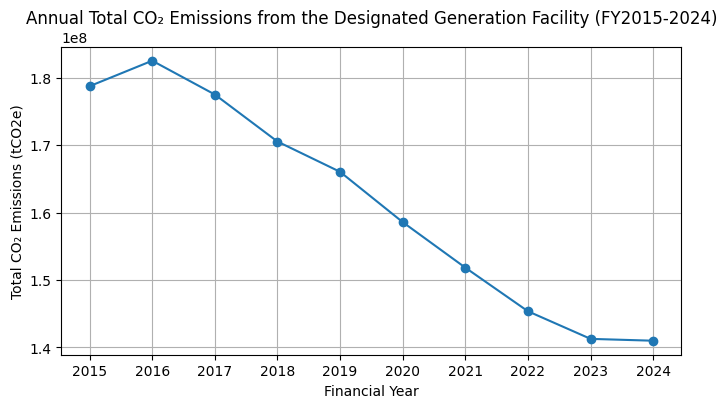

In [29]:
# 2. Historic trend of CO2 emission
agg_emis = NGER_df.groupby("financial_year")["total_emissions_tco2e"].sum().reset_index()

plt.figure(figsize=(8,4))
plt.plot(agg_emis['financial_year'], agg_emis['total_emissions_tco2e'], marker='o')
plt.xticks(agg_prod['financial_year'].sort_values())
plt.xlabel("Financial Year")
plt.ylabel("Total CO₂ Emissions (tCO2e)")
plt.title("Annual Total CO₂ Emissions from the Designated Generation Facility (FY2015-2024)")
plt.grid(True)
plt.show()


In [30]:
# 3. Total production and emission by states in the last ten years
agg_state = NGER_df.groupby("state")[["electricity_production_mwh","total_emissions_tco2e"]].sum().reset_index()
agg_state.sort_values("electricity_production_mwh", ascending=False)

,state,electricity_production_mwh,total_emissions_tco2e
1,NSW,665033065,483686668
3,QLD,598004868,464849802
6,VIC,473593591,466574252
7,WA,246829226,152826013
4,SA,115365623,30733652
5,TAS,106095286,1796185
2,NT,22608587,12888800
0,ACT,1125341,29116


In [31]:
print(Integ_df["primary_fuel"].unique())

['Wind' 'Solar' 'Hydro' 'Black Coal' 'Gas' 'Landfill Gas' 'Brown Coal'
 'Coal Seam Methane' 'Macadamia Nut Shells' 'Gas/Diesel' 'Biogas'
 'Liquid Fuel' 'Bagasse' 'Diesel' 'Wind/Diesel' 'Waste Coal Mine Gas'
 'Multiple sources' 'Biofuel' 'Kerosene' 'Battery' 'Sludge Biogas' 'Wood'
 'Sewage Gas and Biomass-Based Components of Sewage' 'Agricultural Waste'
 'Biomass-Based Components of Municipal Solid Waste' 'Biomass']


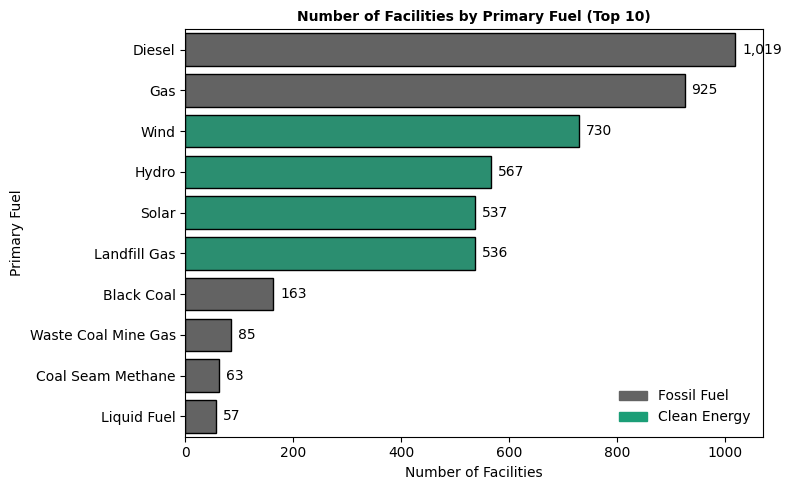

In [32]:
# 4. Number of Facilities by Primary Fuel
plt.figure(figsize=(8, 5))

fuel_cnt = (
    df.groupby("primary_fuel", dropna=False)
      .size()
      .sort_values(ascending=False)
      .head(10)
      .reset_index(name="count")
)

# Define categories
fossil_fuels = {"Black Coal", "Brown Coal", "Gas", "Coal Seam Methane",
    "Waste Coal Mine Gas", "Diesel", "Liquid Fuel", "Gas/Diesel", "Kerosene"}
clean_energy = { "Wind", "Solar", "Hydro", "Landfill Gas", "Biogas", "Bagasse", "Biofuel",
    "Sludge Biogas", "Wood", "Sewage Gas and Biomass-Based Components of Sewage",
    "Agricultural Waste", "Biomass-Based Components of Municipal Solid Waste", "Biomass",
    "Macadamia Nut Shells"}

# Color scheme (softer tones)
fossil_color = "#636363"   # Gray for fossil fuels
clean_color = "#1b9e77"    # Green for clean energy

# Assign colors based on category
colors = []
for fuel in fuel_cnt["primary_fuel"]:
    if fuel in fossil_fuels:
        colors.append(fossil_color)
    elif fuel in clean_energy:
        colors.append(clean_color)

ax = sns.barplot(
    data=fuel_cnt,
    y="primary_fuel",
    x="count",
    hue="primary_fuel",
    palette=colors,
    dodge=False,
    edgecolor="black",
    legend=False
)

ax.set_title("Number of Facilities by Primary Fuel (Top 10)", fontsize=10, weight="bold")
ax.set_xlabel("Number of Facilities")
ax.set_ylabel("Primary Fuel")

# Add value annotations on bars
for p in ax.patches:
    w = p.get_width()
    ax.annotate(
        f"{int(w):,}",  # formatted with thousands separator
        (w, p.get_y() + p.get_height() / 2),
        va="center", ha="left",
        xytext=(5, 0),
        textcoords="offset points"
    )

# Custom legend (only two categories)
legend_handles = [
    Patch(color=fossil_color, label="Fossil Fuel"),
    Patch(color=clean_color, label="Clean Energy")
]
ax.legend(handles=legend_handles, loc="lower right", frameon=False)

plt.tight_layout()
plt.show()


## 3. Data Augmentation

### (1) Configuration

In [33]:
# Configuration

API_KEY = "YOUR_GOOGLE_API_KEY_HERE"  
CACHE_FILE = "cache.txt" # Create a cache file so API results are stored and reused


def address_details(query, api_key=API_KEY, wait=0.1):
    """
    Send a request to the Google Geocoding API for a given address query.
    """
    url = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {"address": query, "key": api_key}
    time.sleep(wait)  # throttle requests
    response = requests.get(url, params=params, timeout=30)
    response.raise_for_status()
    return response.json()

# Load existing cache if available

if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, "r", encoding="utf-8") as f:
        cache = json.load(f)
else:
    cache = {}

latitudes, longitudes, qualities = [], [], []

### (2)  Geocoding

In [34]:
# Iterate over rows and geocode

for i, row in tqdm(Integ_df.iterrows(), total=len(Integ_df)):
    facility = str(row["facility_name"]).strip() if pd.notna(row["facility_name"]) else None
    state = str(row["state"]).strip() if "state" in Integ_df.columns and pd.notna(row["state"]) else None
    postcode = str(row["postcode"]).strip() if pd.notna(row["postcode"]) else None

    parts = []
    if facility:
        parts.append(facility)
    if postcode:
        parts.append(postcode)
    elif state:
        parts.append(state)
    parts.append("Australia")
    q = ", ".join(parts)

    # use cache if available
    if q in cache:
        d = cache[q]
        lat, lon, quality = d.get("lat"), d.get("lon"), d.get("quality", "unknown")
    else:
        data = address_details(q, api_key=API_KEY)
        if data.get("status") == "OK" and len(data["results"]) > 0:
            location = data["results"][0]["geometry"]["location"]
            lat, lon = location["lat"], location["lng"]

            # Keep Google API's original location_type as quality
            quality = data["results"][0]["geometry"].get("location_type", "unknown")

            cache[q] = {"lat": lat, "lon": lon, "quality": quality}
        else:
            lat, lon, quality = None, None, "unmatched"
            cache[q] = {"lat": None, "lon": None, "quality": quality}

    latitudes.append(lat)
    longitudes.append(lon)
    qualities.append(quality)


# Save updated cache

with open(CACHE_FILE, "w", encoding="utf-8") as f:
    json.dump(cache, f, ensure_ascii=False, indent=2)


# Add lat/lon back into Integ_df

Integ_df["lat"] = latitudes
Integ_df["lon"] = longitudes

print("✅ Latitude/Longitude columns have been added to Integ_df")
Integ_df.to_csv("clean_data/Full_clean.csv", index = False)

100%|██████████| 5224/5224 [00:00<00:00, 8704.44it/s]


✅ Latitude/Longitude columns have been added to Integ_df


### (3)  Evaluation

In [35]:
# Build summary (precise / approximate / unmatched)

counter = Counter(qualities)
total = len(qualities)

summary_df = pd.DataFrame(
    {
        "Status": list(counter.keys()) + ["Total"],
        "Count": list(counter.values()) + [total],
    }
)
summary_df["Percentage"] = (summary_df["Count"] / total * 100).round(1).astype(str) + "%"

print("\n--- Geocoding Quality Summary ---")
print(summary_df)


--- Geocoding Quality Summary ---
             Status  Count Percentage
0  GEOMETRIC_CENTER   1436      27.5%
1           ROOFTOP    815      15.6%
2       APPROXIMATE   2973      56.9%
3             Total   5224     100.0%


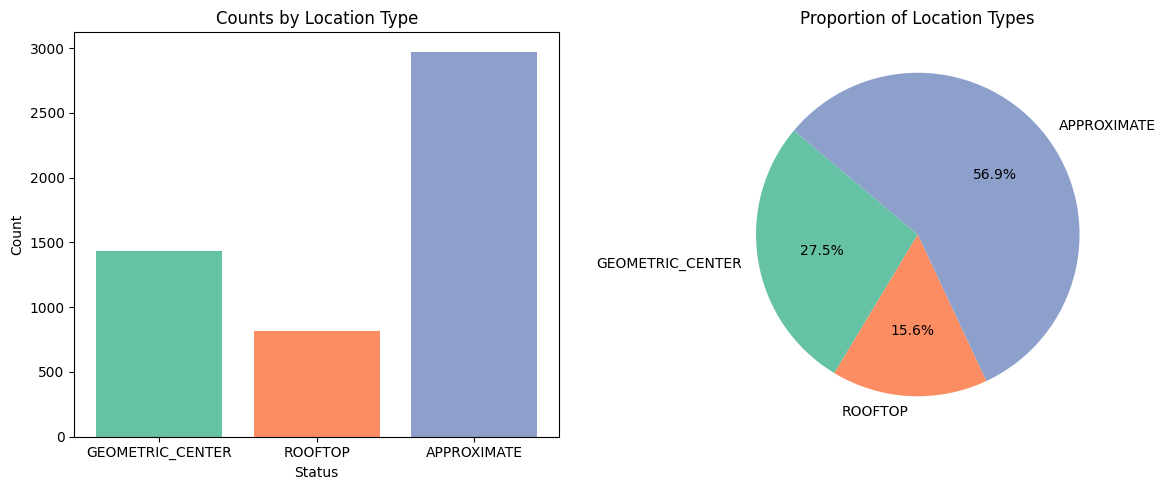

In [36]:
# drop "Total" row for visualization
plot_df = summary_df[summary_df["Status"] != "Total"]

# Create figure with two subplots in one row
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ["#66c2a5", "#fc8d62", "#8da0cb"]     

# --- Bar Chart ---
axes[0].bar(plot_df["Status"], plot_df["Count"], color=colors)
axes[0].set_title("Counts by Location Type")
axes[0].set_xlabel("Status")
axes[0].set_ylabel("Count")

# --- Pie Chart ---
axes[1].pie(
    plot_df["Count"],
    labels=plot_df["Status"],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
axes[1].set_title("Proportion of Location Types")

plt.tight_layout()
plt.show()


## 4. Data Transformation and Storage

In [38]:
# Reload the sql extension if already loaded, otherwise load it
try:
    %reload_ext sql
    print("SQL extension reloaded.")
except:
    %load_ext sql
    print("SQL extension loaded.")

# Create a fresh DuckDB connection (a new file will be created)
%sql duckdb:///australian_energy.db


SQL extension reloaded.


In [39]:
%sql INSTALL spatial

Success


In [40]:
%sql LOAD spatial

Success


In [41]:
%sql SET python_scan_all_frames=True

Success


In [42]:
df = pd.read_csv('clean_data/Full_clean.csv')

#Geocoding and converting data into a format suitable for spatial databases
df['geom'] = gpd.points_from_xy(df.lon, df.lat)
#remove the redundent lat and lon
df = df.drop(columns=['lat','lon'])
srid =4326
df['geom'] = df['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

df.head(3)

,reporting_entity,facility_name,type,state,electricity_production_gj,electricity_production_mwh,scope1_emissions_tco2e,scope2_emissions_tco2e,total_emissions_tco2e,emission_intensity_tco2emwh,...,grid,primary_fuel,financial_year,flag,total_number_of_businesses,total_number_of_business_entries,total_number_of_business_exits,postcode,installed_capacity_mw,geom
0,ACCIONA ENERGY OCEANIA PTY LTD,Gunning Wind Farm,F,NSW,567719.0,157700.0,19.0,293.0,312.0,0.0,...,NEM,Wind,2015.0,NGER,NaN,NaN,NaN,NaN,NaN,POINT (149.4270092 -34.6905625)
1,ACCIONA ENERGY OCEANIA PTY LTD,Royalla Solar Farm,F,ACT,213115.0,59199.0,0.0,15.0,15.0,0.0,...,NEM,Solar,2015.0,NGER,NaN,NaN,NaN,NaN,NaN,POINT (149.1430018 -35.4897929)
2,ACCIONA ENERGY OCEANIA PTY LTD,Waubra Wind Farm,F,VIC,2461803.0,683834.0,77.0,1144.0,1221.0,0.0,...,NEM,Wind,2015.0,NGER,NaN,NaN,NaN,NaN,NaN,POINT (143.6386011 -37.3946388)


In [43]:
%%sql 
DROP TABLE IF EXISTS integration;

--Create an integrated wide table to store the cleaned and augmented data
--Create fields according to the DataFrame column names
CREATE TABLE integration (
    reporting_entity              VARCHAR,
    facility_name                 VARCHAR,
    type                          VARCHAR,
    state                         VARCHAR(10),

    electricity_production_gj     DOUBLE,
    electricity_production_mwh    DOUBLE,
    scope1_emissions_tco2e        DOUBLE,
    scope2_emissions_tco2e        DOUBLE,
    total_emissions_tco2e         DOUBLE,
    emission_intensity_tco2emwh   DOUBLE,

    grid_connected                VARCHAR,
    grid                          VARCHAR,
    primary_fuel                  VARCHAR,

    financial_year                INTEGER,
    flag                          VARCHAR(10),

    total_number_of_businesses    DOUBLE,
    total_number_of_business_entries DOUBLE,
    total_number_of_business_exits   DOUBLE,

    postcode                      VARCHAR(10),
    installed_capacity_mw         DOUBLE,

    geom GEOMETRY 
);

Count


In [44]:
%%sql 
--load dataframe into the integration table as a staging table
INSERT INTO integration SELECT * FROM df;

SELECT * FROM integration
LIMIT 3

reporting_entity,facility_name,type,state,electricity_production_gj,electricity_production_mwh,scope1_emissions_tco2e,scope2_emissions_tco2e,total_emissions_tco2e,emission_intensity_tco2emwh,grid_connected,grid,primary_fuel,financial_year,flag,total_number_of_businesses,total_number_of_business_entries,total_number_of_business_exits,postcode,installed_capacity_mw,geom
ACCIONA ENERGY OCEANIA PTY LTD,Gunning Wind Farm,F,NSW,567719.0,157700.0,19.0,293.0,312.0,0.0,On,NEM,Wind,2015,NGER,None,None,None,None,None,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\xea\xa22\x0f\xaa\xadb@\x08\xac\x1cZdXA\xc0'
ACCIONA ENERGY OCEANIA PTY LTD,Royalla Solar Farm,F,ACT,213115.0,59199.0,0.0,15.0,15.0,0.0,On,NEM,Solar,2015,NGER,None,None,None,None,None,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x9d\xc8\x82x\x93\xa4b@\x10\xa8\xa3\x88\xb1\xbeA\xc0'
ACCIONA ENERGY OCEANIA PTY LTD,Waubra Wind Farm,F,VIC,2461803.0,683834.0,77.0,1144.0,1221.0,0.0,On,NEM,Wind,2015,NGER,None,None,None,None,None,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x11\xf6\x92ko\xf4a@\xc9\xdd1\x86\x83\xb2B\xc0'


In [45]:
%%sql 

-- creat a new schema elec(star schema)
CREATE SCHEMA IF NOT EXISTS elec;


DROP TABLE IF EXISTS elec.economy;
DROP TABLE IF EXISTS elec.energy;
DROP TABLE IF EXISTS elec.grid;
DROP TABLE IF EXISTS elec.facility;
DROP TABLE IF EXISTS elec.time;

-- time dimension table
CREATE TABLE elec.time (
    financial_year INTEGER PRIMARY KEY,
    start_date DATE,
    end_date DATE
);

-- facility dimension table 
CREATE TABLE elec.facility (
    facility_id INTEGER PRIMARY KEY,
    facility_name VARCHAR,
    reporting_entity VARCHAR,
    type VARCHAR,
    cer_fuel VARCHAR,
    state VARCHAR(10),
    geom GEOMETRY,                 
    installed_capacity_mw DOUBLE,
    flag VARCHAR
);

-- grid dimension table
CREATE TABLE elec.grid (
    grid_id INTEGER PRIMARY KEY,
    grid_connected VARCHAR,        
    grid VARCHAR,                
    UNIQUE (grid_connected, grid)
);

-- economy dimension table
CREATE TABLE elec.economy (
    state VARCHAR(50),
    financial_year INTEGER REFERENCES elec.time(financial_year),
    total_number_of_businesses       DOUBLE,
    total_number_of_business_entries DOUBLE,
    total_number_of_business_exits   DOUBLE,
    PRIMARY KEY (state, financial_year)
);

-- energy fact table
CREATE TABLE elec.energy (
    facility_id INTEGER REFERENCES elec.facility(facility_id),
    financial_year INTEGER REFERENCES elec.time(financial_year),
    grid_id INTEGER REFERENCES elec.grid(grid_id),
    facility_name VARCHAR,
    fuel VARCHAR,
    electricity_production_gj   DOUBLE,
    electricity_production_mwh  DOUBLE,
    scope1_emissions_tco2e      DOUBLE,
    scope2_emissions_tco2e      DOUBLE,
    total_emissions_tco2e       DOUBLE,
    emission_intensity_tco2emwh DOUBLE,
    PRIMARY KEY (facility_id, financial_year)
);


Count


In [46]:
%%sql 
--View all tables in the database and their schemas to confirm whether the tables have been created correctly
SELECT table_schema, table_name
FROM information_schema.tables
ORDER BY table_schema, table_name;

table_schema,table_name
elec,economy
elec,energy
elec,facility
elec,grid
elec,time
main,integration


In [47]:
%%sql 

TRUNCATE TABLE elec.time;

--Generate a time dimension table based on the wide table, and add the start and end dates for each financial year
INSERT INTO elec.time (financial_year, start_date, end_date)
SELECT DISTINCT 
    i.financial_year,
    CAST((i.financial_year - 1) || '-07-01' AS DATE) AS start_date,  
    CAST( i.financial_year       || '-06-30' AS DATE) AS end_date    
FROM main.integration AS i
WHERE i.financial_year IS NOT NULL
ORDER BY 1;

-- verification 
SELECT * FROM elec.time ORDER BY financial_year LIMIT 3;

financial_year,start_date,end_date
2015,2014-07-01,2015-06-30
2016,2015-07-01,2016-06-30
2017,2016-07-01,2017-06-30


In [48]:
%%sql 

TRUNCATE TABLE elec.grid;
--Load the grid dimension table (elec.grid) data
INSERT INTO elec.grid (grid_id, grid_connected, grid)
SELECT
    ROW_NUMBER() OVER (ORDER BY grid_connected, grid) AS grid_id,--Generate surrogate primary keys
    grid_connected,
    grid
FROM (
    SELECT DISTINCT grid_connected, grid
    FROM main.integration
    WHERE grid_connected IS NOT NULL AND grid IS NOT NULL
) t
ORDER BY grid_connected, grid;

-- verification
SELECT * FROM elec.grid ORDER BY grid_id LIMIT 3

grid_id,grid_connected,grid
1,Off,Off-grid
2,On,DKIS
3,On,Mt Isa


In [49]:
%%sql 

TRUNCATE TABLE elec.facility;

INSERT INTO elec.facility (
    facility_id, facility_name, reporting_entity, type,
    cer_fuel, state, geom, installed_capacity_mw, flag
)
    
--Create a temporary table to deduplicate multiple rows in the wide table main.integration, retaining only one representative record for each power station.
WITH latest_per_kind AS (
    SELECT
        facility_name,
        state,
        reporting_entity,       
        type,
        primary_fuel,
        flag,                                       
        geom,
        installed_capacity_mw,
        financial_year,
        ROW_NUMBER() OVER (
            --Group by (facility_name, state, reporting_entity)
            --Ensure that power station records with the same name, state and entity are considered a group,
            PARTITION BY facility_name, state,reporting_entity
            ORDER BY financial_year DESC
        ) AS rn
    FROM main.integration
    WHERE facility_name IS NOT NULL AND state IS NOT NULL
)
SELECT
    ROW_NUMBER() OVER (ORDER BY facility_name, state, reporting_entity) AS facility_id,  
    facility_name,
    reporting_entity,
    type,
    CASE WHEN flag='CER' THEN primary_fuel END   AS cer_fuel,-- only CER remain for planned fuel type
    state,
    geom,                                                            
    installed_capacity_mw, 
    flag
FROM latest_per_kind
WHERE rn = 1
ORDER BY 1;

--verification
SELECT * FROM elec.facility LIMIT 3

facility_id,facility_name,reporting_entity,type,cer_fuel,state,geom,installed_capacity_mw,flag
1,123 Sippy Downs,None,None,Solar,QLD,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00w\xf5*2\xfa!c@\xe2O\x9e\xc3\xc6\xb6:\xc0',0.2,CER
2,AFS Cadell Balranald,None,None,Solar,NSW,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00F>T\xbf\xf7\xefa@\xbf\xe6\xb0VH\\A\xc0',4.827,CER
3,ATCO Gas Australia Jandakot Microgrid,None,None,Solar,WA,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\xdd\x9c\xa5\xbf\xf2\xf6\\@\x93i\xd9\xff\xa5\x0e@\xc0',0.301,CER


In [50]:
%%sql 
TRUNCATE TABLE elec.energy;

--import NGER data from wide tables to generate energy fact tables
INSERT INTO elec.energy (
    facility_id, financial_year, grid_id, facility_name, fuel,
    electricity_production_gj, electricity_production_mwh,
    scope1_emissions_tco2e, scope2_emissions_tco2e,
    total_emissions_tco2e, emission_intensity_tco2emwh
)
SELECT
    f.facility_id,
    i.financial_year,
    g.grid_id,
    f.facility_name,                    
    i.primary_fuel AS fuel,
    i.electricity_production_gj,
    i.electricity_production_mwh,
    i.scope1_emissions_tco2e,
    i.scope2_emissions_tco2e,
    i.total_emissions_tco2e,
    i.emission_intensity_tco2emwh
FROM main.integration i
--Associate the facility dimension and find the corresponding facility_id
JOIN elec.facility f ON f.facility_name=i.facility_name 
    AND f.state=i.state 
    AND f.reporting_entity= i.reporting_entity
--Associate the grid dimension and find the corresponding grid_id
JOIN elec.grid g ON g.grid_connected=i.grid_connected
    AND g.grid=i.grid
WHERE i.flag='NGER';

--verification
SELECT * FROM elec.energy LIMIT 3

facility_id,financial_year,grid_id,facility_name,fuel,electricity_production_gj,electricity_production_mwh,scope1_emissions_tco2e,scope2_emissions_tco2e,total_emissions_tco2e,emission_intensity_tco2emwh
701,2015,4,Gunning Wind Farm,Wind,567719.0,157700.0,19.0,293.0,312.0,0.0
1451,2015,4,Royalla Solar Farm,Solar,213115.0,59199.0,0.0,15.0,15.0,0.0
1738,2015,4,Waubra Wind Farm,Wind,2461803.0,683834.0,77.0,1144.0,1221.0,0.0


In [51]:
%%sql 
TRUNCATE TABLE elec.economy;

--Load ABS economy indicators into elec.economy
INSERT INTO elec.economy (
    state, financial_year,
    total_number_of_businesses,
    total_number_of_business_entries,
    total_number_of_business_exits
)
--Extract unique economic indicator records for each state in each year and remove duplicate rows
SELECT DISTINCT
    i.state,
    i.financial_year,
    i.total_number_of_businesses,
    i.total_number_of_business_entries,
    i.total_number_of_business_exits
FROM main.integration i
WHERE i.state IS NOT NULL
    AND i.financial_year IS NOT NULL
ORDER BY i.state, i.financial_year;

--Check
SELECT * FROM elec.economy
ORDER BY financial_year DESC, state DESC
LIMIT 3;

state,financial_year,total_number_of_businesses,total_number_of_business_entries,total_number_of_business_exits
WA,2024,255396.0,40902.0,32653.0
VIC,2024,737915.0,124588.0,105612.0
TAS,2024,44029.0,6056.0,5247.0


In [52]:
%sql --close duckdb:///australian_energy.db